<a href="https://colab.research.google.com/github/Nielk74/ia-clothes/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Présentation

Ce notebook présente une méthode de clustering de couleurs extraites à partir de ce [notebook](https://colab.research.google.com/drive/19Hn6Y-09XlVNDg7Hp798v5ZL41UBsx8S?usp=sharing).

# Setup

In [ ]:
!wget https://raw.githubusercontent.com/Nielk74/ia-clothes/master/input.csv

--2023-12-11 20:34:57--  https://raw.githubusercontent.com/Nielk74/ia-clothes/master/input.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93333 (91K) [text/plain]
Saving to: ‘input.csv’

input.csv           100%[===================>]  91.15K  --.-KB/s    in 0.003s  

2023-12-11 20:34:57 (27.1 MB/s) - ‘input.csv’ saved [93333/93333]



In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install colour-science


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.8 MB/s eta 0:00:00


# Clustering

Import de dépendances

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import colour
from colour.models import RGB_COLOURSPACE_sRGB
import csv

Récupération de paramètres

In [ ]:
clothes_cluster_nb = 20 # int(input("Saisissez le nombre de cluster souhaité pour les couleurs de vêtements : "))
nb_cluster_skin = 5 # int(input("Saisissez le nombre de cluster souhaité pour les couleurs de peau : "))

In [ ]:
def colored_background(r, g, b, text):
    return f'\033[48;2;{r};{g};{b}m{text}\033[0m'


def normalize_to_srgb(rgb):
    return np.dot(1/255,rgb)

def get_data_from_input(path):
    dict_skin = {}

    with open(path, 'r' ) as infile:
        reader = csv.reader(infile, delimiter=';')
        for row in reader:
            if 'None' in row[1] or 'None' in row[2] or 'None' in row[3]:
                continue

            skin_column = row[3].strip()
            upper_column = row[2].strip()
            lower_column = row[1].strip()

            rgb_skin = np.array(skin_column.split(',')).astype(np.uint8)
            rgb_upper = np.array(upper_column.split(',')).astype(np.uint8)
            rgb_lower = np.array(lower_column.split(',')).astype(np.uint8)
            dict_skin[str(rgb_skin)] = {'upper':rgb_upper,'lower':rgb_lower, 'skin': rgb_skin, 'path':row[0]}
    return dict_skin

color_space = (RGB_COLOURSPACE_sRGB,)

def clustering(num_clusters, data):
    kmeans = KMeans(n_clusters=num_clusters, n_init=num_clusters)

    lab_data = np.apply_along_axis(normalize_to_srgb, 1, data)
    lab_data = np.apply_along_axis(colour.RGB_to_XYZ, 1, lab_data, *color_space)
    lab_data = np.apply_along_axis(colour.XYZ_to_Lab, 1, lab_data)

    kmeans.fit(lab_data)

    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    return cluster_labels, cluster_centers

def get_occurences_by_skin_cluster(skin_cluster, occurences):
    occurences_by_skin_cluster = {}
    for key, value in occurences.items():
        if value['skin_cluster'] == skin_cluster:
            occurences_by_skin_cluster[key] = value
    occurences_by_skin_cluster = {k: v for k, v in sorted(occurences_by_skin_cluster.items(), key=lambda item: item[1]['occurences'], reverse=True)}
    return occurences_by_skin_cluster

def lab_to_rgb(lab):
    lab = np.array(lab)
    lab = np.reshape(lab, (1,3))
    lab = np.apply_along_axis(colour.Lab_to_XYZ, 1, lab)
    lab = np.apply_along_axis(colour.XYZ_to_RGB, 1, lab, *color_space)
    lab = np.apply_along_axis(np.dot, 1, lab, 255)
    return lab[0]

dict_skin = get_data_from_input('input.csv')

skin_data = []
upper_data =[]
lower_data = []

nb_cluster_upper = clothes_cluster_nb
nb_cluster_lower = clothes_cluster_nb

for data in dict_skin.items():
    skin_data.append(data[1]['skin'])
    upper_data.append(data[1]['upper'])
    lower_data.append(data[1]['lower'])

skin_data = np.array(skin_data)
upper_data = np.array(upper_data)
lower_data = np.array(lower_data)

cluster_labels_skin, cluster_centers_skin = clustering(nb_cluster_skin, skin_data)
cluster_labels_upper, cluster_centers_upper = clustering(nb_cluster_upper, upper_data)
cluster_labels_lower, cluster_centers_lower = clustering(nb_cluster_lower, lower_data)

occurences = {}

for data in dict_skin.items():
    skin = data[1]['skin']
    upper = data[1]['upper']
    lower = data[1]['lower']
    path = data[1]['path']

    skin_cluster = cluster_labels_skin[np.where((skin_data == skin).all(axis=1))][0]
    upper_cluster = cluster_labels_upper[np.where((upper_data == upper).all(axis=1))][0]
    lower_cluster = cluster_labels_lower[np.where((lower_data == lower).all(axis=1))][0]

    rgb_upper = lab_to_rgb(cluster_centers_upper[upper_cluster])
    rgb_lower = lab_to_rgb(cluster_centers_lower[lower_cluster])
    diff_upper = abs(rgb_upper[0] - rgb_upper[1]) + abs(rgb_upper[1] - rgb_upper[2]) + abs(rgb_upper[0] - rgb_upper[2])
    diff_lower = abs(rgb_lower[0] - rgb_lower[1]) + abs(rgb_lower[1] - rgb_lower[2]) + abs(rgb_lower[0] - rgb_lower[2])
    key = str(skin_cluster) + str(upper_cluster) + str(lower_cluster)

    if key in occurences:
        occurences[key]['occurences'] += 1
    else:
        occurences[key] = {'skin_cluster': skin_cluster, 'upper_cluster': upper_cluster, 'lower_cluster': lower_cluster, 'occurences': 1, 'path': path}

list_skin_rgb = []
for skin_cluster in range(nb_cluster_skin):
    list_skin_rgb.append({"color":lab_to_rgb(cluster_centers_skin[skin_cluster]), "num_cluster":skin_cluster})

# tri des teintes de peau par luminance
list_skin_rgb = sorted(list_skin_rgb, key=lambda x: x["color"][0])
for skin in list_skin_rgb:
    print(colored_background(int(skin["color"][0]), int(skin["color"][1]), int(skin["color"][2]), ' '), end=' ')

# sélection de la teinte de peau par l'utilisateur
print('\n')
skin_choice = int(input('Choose skin cluster ( 1-'+str(nb_cluster_skin)+' ) : '))
skin_cluster = list_skin_rgb[skin_choice-1]["num_cluster"]

occurences_by_skin_cluster = get_occurences_by_skin_cluster(skin_cluster, occurences)
print("For the skin tone : " + colored_background(int(list_skin_rgb[skin_choice-1]["color"][0]), int(list_skin_rgb[skin_choice-1]["color"][1]), int(list_skin_rgb[skin_choice-1]["color"][2]), '           '))
for i in range(10):
    key = list(occurences_by_skin_cluster.keys())[i]
    value = occurences_by_skin_cluster[key]
    rgb_upper = lab_to_rgb(cluster_centers_upper[value['upper_cluster']])
    rgb_lower = lab_to_rgb(cluster_centers_lower[value['lower_cluster']])
    print("Occurences : " + str(value['occurences']), end=' ')
    print(colored_background(int(rgb_upper[0]), int(rgb_upper[1]), int(rgb_upper[2]), f'Upper {value["upper_cluster"]}'), end=' ')
    print(colored_background(int(rgb_lower[0]), int(rgb_lower[1]), int(rgb_lower[2]), f'Lower {value["lower_cluster"]}'), end=' ')
    print("Exemple d'image : " + value['path'])
    print("\n")


          

Choose skin cluster ( 1-5 ) : 3
For the skin tone :            
Occurences : 24 Upper 16 Lower 1 Exemple d'image : 00006908-01_1_front 


Occurences : 18 Upper 11 Lower 1 Exemple d'image : 00000294-01_4_full 


Occurences : 15 Upper 1 Lower 1 Exemple d'image : 00000638-03_4_full 


Occurences : 14 Upper 5 Lower 1 Exemple d'image : 00002702-01_4_full 


Occurences : 11 Upper 1 Lower 15 Exemple d'image : 00003393-01_4_full 


Occurences : 11 Upper 16 Lower 15 Exemple d'image : 00000945-03_4_full 


Occurences : 11 Upper 16 Lower 5 Exemple d'image : 00005213-04_4_full 


Occurences : 8 Upper 6 Lower 1 Exemple d'image : 00000321-01_1_front 


Occurences : 6 Upper 6 Lower 15 Exemple d'image : 00001866-08_7_additional 


Occurences : 6 Upper 17 Lower 1 Exemple d'image : 00001246-01_4_full 




In [ ]:
!pip install transformers
!pip install torch
!pip install extcolors

In [ ]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import extcolors
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import torch

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
def get_skin_color(image):
  def getColorDominantFromMask(image, mask):
    # apply mask
    binary_mask = (mask * 255).astype(np.uint8)

    # convert PIL image to openCV image
    imageCV = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGRA)

    # add the forth dimension (opacity)
    four_channel_mask = cv2.merge([binary_mask] * 4)

    # Apply mask
    result = cv2.bitwise_and(imageCV, four_channel_mask)

    # Convert to PIL image
    pil_image = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGBA))

    # get dominant color
    colors, pixel_count = extcolors.extract_from_image(pil_image)
    return colors[0][0]


  inputs = processor(images=image, return_tensors="pt").to(device)
  outputs = model(**inputs)
  logits = outputs.logits.cpu()

  upsampled_logits = nn.functional.interpolate(
      logits,
      size=image.size[::-1],
      mode="bilinear",
      align_corners=False,
  )

  # Get the segmentation prediction
  pred_seg = upsampled_logits.argmax(dim=1)[0]
  rows, cols = pred_seg.shape

  skin_mask = np.full((rows,cols), False, dtype=bool)
  segmentation = pred_seg.detach().cpu().numpy()
  has_skin = False

  for i in range(rows):
      for j in range(cols):
        v = segmentation[i, j]
        if v in [11,12,13,14,15]: #body parts
          skin_mask[i,j]=  True
          has_skin = True

  return getColorDominantFromMask(image,skin_mask)

Saving mannequin.webp to mannequin (1).webp
skin_color 

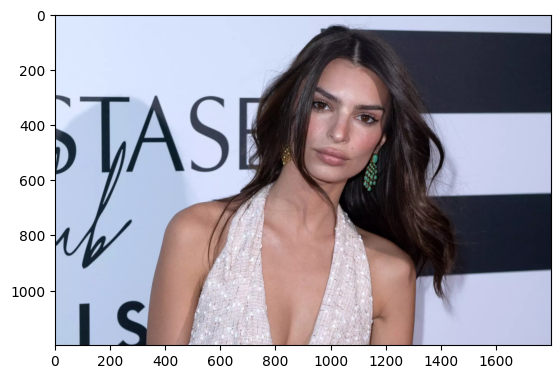

In [ ]:
from google.colab import files
src = list(files.upload().values())[0] # upload image
open('uploaded_image.jpg','wb').write(src)
image= Image.open('uploaded_image.jpg')
plt.imshow(image)
skin_color = get_skin_color(image)
print(colored_background(int(skin_color[0]), int(skin_color[1]), int(skin_color[2]), "skin_color"), end=' ')

In [ ]:
rgb_input = normalize_to_srgb(skin_color)
lab_input = colour.RGB_to_XYZ(rgb_input, *color_space)
lab_input = colour.XYZ_to_Lab(lab_input)
# find the closest skin cluster
closest_skin_cluster = 0
closest_skin_cluster_distance = 10000
for skin_cluster in range(nb_cluster_skin):
    lab_skin_cluster = cluster_centers_skin[skin_cluster]
    distance = np.linalg.norm(lab_input - lab_skin_cluster)
    if distance < closest_skin_cluster_distance:
        closest_skin_cluster_distance = distance
        closest_skin_cluster = skin_cluster

rgb_closest_skin_cluster = lab_to_rgb(cluster_centers_skin[closest_skin_cluster])
print(colored_background(int(rgb_closest_skin_cluster[0]), int(rgb_closest_skin_cluster[1]), int(rgb_closest_skin_cluster[2]), 'closest skin cluster number ' + str(closest_skin_cluster)), end=' ')

closest skin cluster number 0 